# Bitcoin USD - Time Series Forecasting

# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data
The dataset is a mix of CSV files for select bitcoin exchanges for the time period of Jan 2012 to December March 2021, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. 

Source of Datasets:

Created by Zielak,
Neuroscience Ph.D. - Data Scientist <br>
https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
    #MASTER
    import tensorflow as tf

    #########BASIC
    import numpy as np 
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import r2_score
    from sklearn.metrics import accuracy_score

    ######## GRAPHICAL
    from plotly import tools
    from plotly.offline import init_notebook_mode, iplot
    init_notebook_mode(connected=True)
    import plotly.graph_objs as go
    import gc
    import matplotlib.pyplot as plt

    ######## STATISTICAL
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    from matplotlib import pyplot
    import matplotlib.pyplot as plt

    ######### RNN
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Activation

    ######## FB PROPHET
    from prophet import Prophet
    from prophet.utilities import regressor_coefficients
    from prophet.diagnostics import cross_validation, performance_metrics
    from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

    ########ARIMAX
    import pmdarima as pm

    ######### WARNINGS
    import warnings
    warnings.filterwarnings('ignore')

## <font color= blue >2. Loading the dataset </font> <a class="anchor" id="third-bullet"></a>

In [9]:
cols = ['Date','Open','High','Low','Close','Volume','Adj_Close']

#BTC Data
data_btc = pd.read_csv('data_BTC-USD.csv')
data_btc["Date"] = data_btc["Date"].astype("datetime64[ns]")
data_btc = data_btc.rename(columns={'Adj Close': 'Adj_Close'})
data_btc = data_btc[cols]

#ETH Data
data_eth = pd.read_csv('data_ETH-USD.csv')
data_eth["Date"] = data_eth["Date"].astype("datetime64[ns]")
data_eth = data_eth.rename(columns={'Adj Close': 'Adj_Close'})
data_eth = data_eth[cols]

#BNB Data
data_bnb = pd.read_csv('data_bnb.csv')
data_bnb["Date"] = data_bnb["Date"].astype("datetime64[ns]")
data_bnb = data_bnb.rename(columns={'Adj Close': 'Adj_Close'})
data_bnb = data_bnb[cols]

#ADA Data
data_ada = pd.read_csv('data_ada.csv')
data_ada["Date"] = data_ada["Date"].astype("datetime64[ns]")
data_ada = data_ada.rename(columns={'Adj Close': 'Adj_Close'})
data_ada = data_ada[cols]

#Crypto
crypto = [data_btc, data_eth, data_bnb, data_ada]

# -------------------------------------------------------------------------------------

## <font color= blue >3. Exploratory Data Analysis </font> <a class="anchor" id="fourth-bullet"></a>

#### Data Exploration

In this section we will explore the Historic Bitcoin Prices and try to find some insights. We will be using the Coinbase dataset as it is one of the mostly used Bitcoin Exchange/Wallet in the world.

In [10]:
print("Data_BTC range:", "\n", data_btc['Date'].agg(['min', 'max']),"\n")
print("Data_ETH range:", "\n", data_eth['Date'].agg(['min', 'max']), "\n")
print("Data_BNB range:", "\n", data_bnb['Date'].agg(['min', 'max']), "\n")
print("Data_ADA range:", "\n", data_ada['Date'].agg(['min', 'max']), "\n")

Data_BTC range: 
 min   2021-01-01
max   2021-12-31
Name: Date, dtype: datetime64[ns] 

Data_ETH range: 
 min   2021-01-01
max   2021-12-31
Name: Date, dtype: datetime64[ns] 

Data_BNB range: 
 min   2017-11-09
max   2022-12-31
Name: Date, dtype: datetime64[ns] 

Data_ADA range: 
 min   2017-11-09
max   2022-12-31
Name: Date, dtype: datetime64[ns] 



In [11]:
data_btc = data_btc.set_index(["Date"])
data_eth = data_eth.set_index(["Date"])
data_bnb = data_bnb.set_index(["Date"])
data_ada = data_ada.set_index(["Date"])
data_btc

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,40730301359,29374.152344
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,67865420765,32127.267578
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,78665235202,32782.023438
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,81163475344,31971.914062
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,67547324782,33992.429688
...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,24324345758,50640.417969
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,33430376883,47588.855469
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,30049226299,46444.710938


In [12]:
data_btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       365 non-null    float64
 1   High       365 non-null    float64
 2   Low        365 non-null    float64
 3   Close      365 non-null    float64
 4   Volume     365 non-null    int64  
 5   Adj_Close  365 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


In [13]:
data_btc.describe()

,Open,High,Low,Close,Volume,Adj_Close
count,365.000000,365.000000,365.000000,365.000000,3.650000e+02,365.000000
mean,47402.115662,48762.998924,45852.003082,47436.932021,4.715574e+10,47436.932021
std,9840.860532,9844.917688,9811.253779,9787.634672,2.473559e+10,9787.634672
min,28994.009766,29600.626953,28722.755859,29374.152344,1.878799e+10,29374.152344
25%,38213.332031,39750.031250,36317.500000,38347.062500,3.237997e+10,38347.062500
50%,47810.687500,49202.878906,46671.964844,47783.359375,4.058521e+10,47783.359375
75%,56191.585938,57793.039062,54288.156250,56216.183594,5.823847e+10,56216.183594
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,67566.828125


#### Missing Values

In this section we will explore any Missing Values present in the dataframe.

In [14]:
# Number of NaNs on each columns 
data_btc.isna().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj_Close    0
dtype: int64

In [15]:
# Function to check wheter or not a particular datasets has missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns


missing_values_table(data_btc)

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [16]:
# Displaying all Dates with missing values information

nan_rows  = data_btc[data_btc.isna().any(axis=1)]
nan_rows.head()

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,


__Interpolation__
Unfortunately, time series, or at least the ones that are worthy of interest, are usually non-stationary. This means that their statistical characteristics — average, variance, and standard deviation — do change with time.

#### Downsampling Data - decreasing the timestamp frequency

Here we decided to downsample the data into days, months, quarters and years for visualization and further analysis.


In [17]:
# Default resampling is set to per Hour. 
# Here we decided to downsample the data into days, months, quarters and years for visualization and further analysis.
df = data_btc.copy()

# Resampling to daily frequency
df_day = df.resample('D').mean()

# Resampling to monthly frequency
df_week = df.resample('W').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to quarterly frequency
df_quarter = df.resample('Q-DEC').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

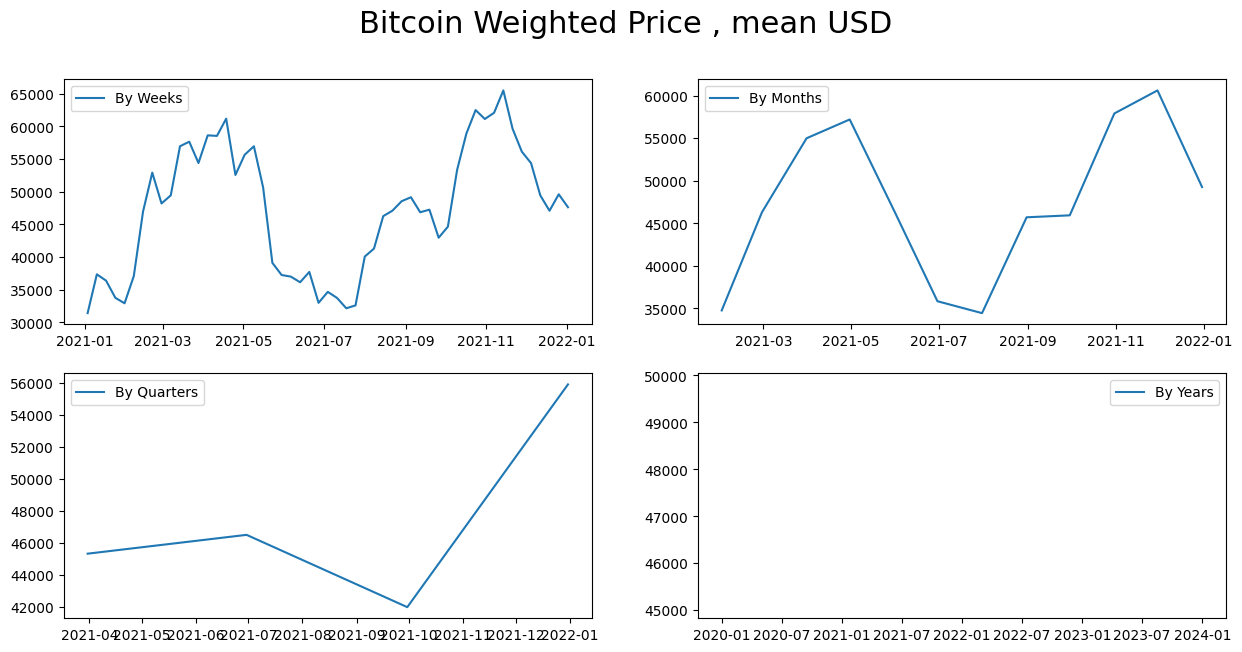

In [18]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Weighted Price , mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_week.Adj_Close, '-', label='By Weeks')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Adj_Close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_quarter.Adj_Close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Adj_Close, '-', label='By Years')
plt.legend()

plt.show()

# -------------------------------------------------------------------------------------

## <font color= blue >4. Data Visualization </font> <a class="anchor" id="fourth-bullet"></a>

In [19]:
# basically creating a range that includes all data
start = '2012-01-01'
end = '2021-01-01'

# find rows between start and end time 
data_monthly = df_month[(df_month.index >= start) & (df_month.index <= end)].reset_index()
data_monthly.head()

,Date,Open,High,Low,Close,Volume,Adj_Close


### Visualize Bitcoin Prices from 2012-2021

In [20]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['Adj_Close'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices (2012-2018) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([

                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

_ = [trace1,trace2, trace3]
fig = dict(data=_, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

### Visualizing Bitcoin Market Volume from 2012-2021

In [21]:
trace1 = go.Scatter(
    x = data_monthly['Date'],
    y = data_monthly['Volume'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2012-2021) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

_= [trace1]
fig = dict(data=_, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

# -------------------------------------------------------------------------------------

#### Selecting the range for our analysis: 2012 -- 2021

There are an incredible amount of challenges in correctly forecasting a time-series analysis for Crypto.
Too many factors drive the price volatility (that historical data in unable to capture). Due to this we decided to range our dataset to exclude the year of 2021 forward, removing the steep upward trend in price

In [22]:
# basically creating a range that includes all data
start = '2012-01-01'
end = '2024-01-01'

# find rows between start and end time 
df_day = df_day[(df_day.index >= start) & (df_day.index <= end)]
df_week = df_week[(df_week.index >= start) & (df_week.index <= end)]
df_month = df_month[(df_month.index >= start) & (df_month.index <= end)]
df_quarter = df_quarter[(df_quarter.index >= start) & (df_quarter.index <= end)]
df_year = df_year[(df_year.index >= start) & (df_year.index <= end)]

# -------------------------------------------------------------------------------------

## <font color= blue >5. Checking stationary vs Non-stationary Data </font> <a class="anchor" id="fifth-bullet"></a>

### ACF and PACF

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'PACF for Weighted Price -- Daily')

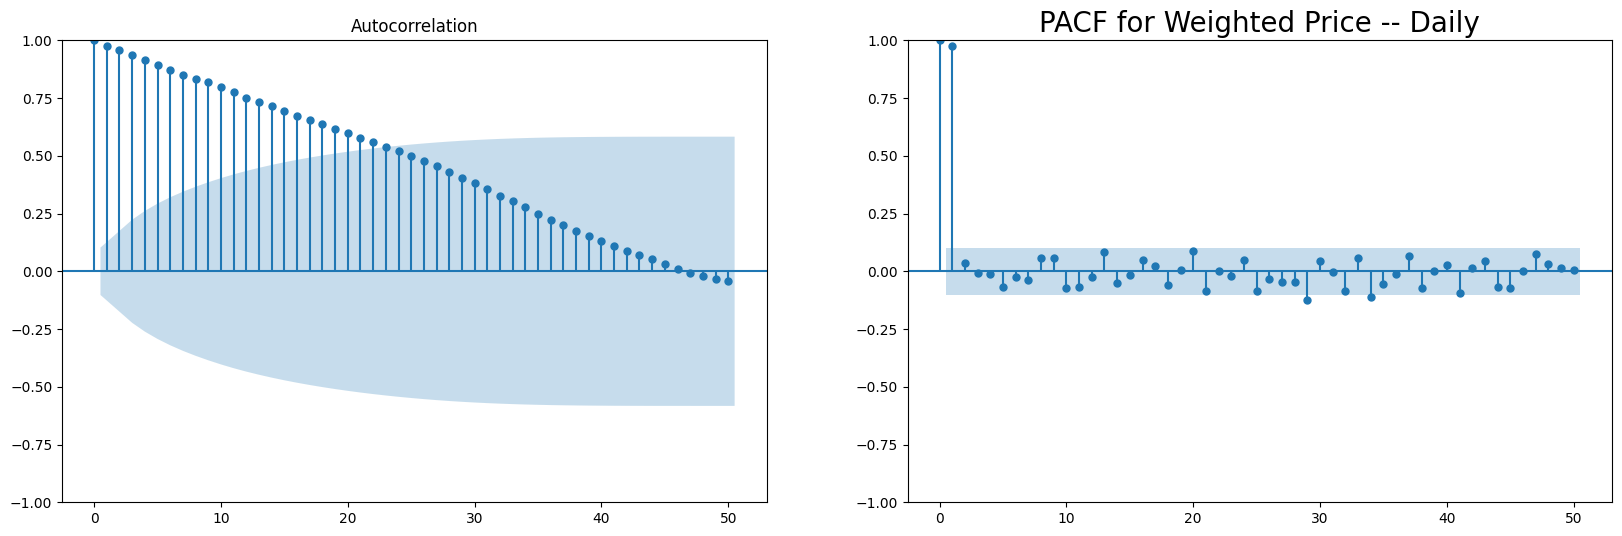

In [24]:
# For daily Frequency ACF and PACF

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

plot_acf(df_day.Adj_Close, lags=50, alpha=0.05, ax=ax1)
plt.title("ACF for Weighted Price", size=20)

plot_pacf(df_day.Adj_Close, lags=50, alpha=0.05, method='ols', ax=ax2)
plt.title("PACF for Weighted Price -- Daily", size=20)

Figure 1 - presents the time series, ACF and PACF plots for the usd prices of the Bitcoin. <br>

### ACF and PACF

Trough visual inspection Figure 1 it is clear that the data values do not have a constant mean and variances.We can observe decaying pattern in ACF plot and the highly significant first lag in PACF. <br>

Autocorrelations are declining gradually as the number of lags such a property is common in nonstationary processes. <br> 

### ADF Augmented Dickey–Fuller test

The formal statistical tool for checking stationarity of time series data is to go for Augumented Dickey Fuller (ADF) test.

__H0: The time series is non-stationary.__<br>
__HA: The time series is stationary.__

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [25]:
## Augmented Dickey–Fuller test

    # "HO: Non-stationary"
    # "H1: Stationary"

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
series = df_day.Adj_Close
X = series.values

In [26]:
# Stability Test (Dickey-Fuller Test)
def is_stationary(y):
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
        
is_stationary(X)

Result: Non-Stationary (H0: non-stationary, p-value: 0.163)


In [27]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.327769
p-value: 0.163168
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


#### Time Series Components

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [29]:
decomposition = sm.tsa.seasonal_decompose(df_month.Adj_Close)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(15,12))

plt.subplot(411)
plt.plot(df_month.Adj_Close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

ValueError: x must have 2 complete cycles requires 24 observations. x only has 12 observation(s)

Post time series decomposition we don't observe any seasonality. Also, there is no constant mean, variance and covariance, hence the series is Non Stationary. 

# -------------------------------------------------------------------------------------

## <font color= blue >6. Normalizing Time Series Data </font> <a class="anchor" id="fifth-bullet"></a>

In [30]:
df_day.head()

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,4.073030e+10,29374.152344
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,6.786542e+10,32127.267578
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,7.866524e+10,32782.023438
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,8.116348e+10,31971.914062
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,6.754732e+10,33992.429688


In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
data_normalized =pd.DataFrame(scaler.fit_transform(df_day), columns=df_day.columns) 

In [27]:
temp=df_day.reset_index()

In [28]:
data_normalized['Date']=temp['Date']

In [29]:
data_normalized=data_normalized.set_index(data_normalized.Date)
data_normalized=data_normalized.drop(columns=['Date'])

In [30]:
data_normalized

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2014-09-17,-0.765553,-0.765841,-0.766676,-0.766551,-0.817295,-0.766551
2014-09-18,-0.766110,-0.766523,-0.769179,-0.768583,-0.816622,-0.768583
2014-09-19,-0.768133,-0.768271,-0.770998,-0.770415,-0.816450,-0.770415
2014-09-20,-0.769951,-0.768545,-0.770657,-0.769543,-0.816503,-0.769543
2014-09-21,-0.769123,-0.769199,-0.770447,-0.770167,-0.817018,-0.770167
...,...,...,...,...,...,...
2022-12-27,0.250865,0.227521,0.263982,0.238217,-0.029805,0.238217
2022-12-28,0.238332,0.215976,0.254782,0.228046,0.033141,0.228046
2022-12-29,0.228196,0.208964,0.255491,0.233593,-0.093712,0.233593


In [31]:
# split data into train and test sets
splitter= '2021-01-01'
data_train = data_normalized.loc[data_normalized.index <= splitter]
data_test = data_normalized.loc[data_normalized.index > splitter]

In [32]:
X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1], data_test.iloc[:, -1]

In [33]:
y_train= y_train.to_numpy()
y_test= y_test.to_numpy()
X_train= X_train.to_numpy()
X_test= X_test.to_numpy()

In [34]:
# reshaping to  3D [samples, timesteps, features]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2299, 1, 5) (2299,) (729, 1, 5) (729,)


In [35]:
X_test

array([[[ 1.02041323,  1.20303057,  1.05651194,  1.19047594,
          2.57972766]],

       [[ 1.19047833,  1.29057745,  1.24502236,  1.23093623,
          3.12048313]],

       [[ 1.23258088,  1.22020343,  1.03305738,  1.18087595,
          3.24557204]],

       ...,

       [[ 0.2281958 ,  0.20896378,  0.25549065,  0.23359318,
         -0.09371234]],

       [[ 0.23369431,  0.20846214,  0.24911119,  0.23113649,
         -0.0207629 ]],

       [[ 0.23136807,  0.20759227,  0.25605316,  0.22773225,
         -0.25559383]]])

In [36]:
test = pd.DataFrame(data_test['Adj_Close'])

In [37]:
train = pd.DataFrame(data_train['Adj_Close'])

In [38]:
pd.concat([train, test], join='outer')

,Adj_Close
Date,
2014-09-17,-0.766551
2014-09-18,-0.768583
2014-09-19,-0.770415
2014-09-20,-0.769543
2014-09-21,-0.770167
...,...
2022-12-27,0.238217
2022-12-28,0.228046
2022-12-29,0.233593


In [39]:
test=test.rename(columns={'Adj_Close': 'Test Set'}) 

In [40]:
train=train.rename(columns={'Adj_Close': 'Train Set'}) 

In [41]:
whole_data=train.join(test, how='outer' )
whole_data.head()

,Train Set,Test Set
Date,,
2014-09-17,-0.766551,NaN
2014-09-18,-0.768583,NaN
2014-09-19,-0.770415,NaN
2014-09-20,-0.769543,NaN
2014-09-21,-0.770167,NaN


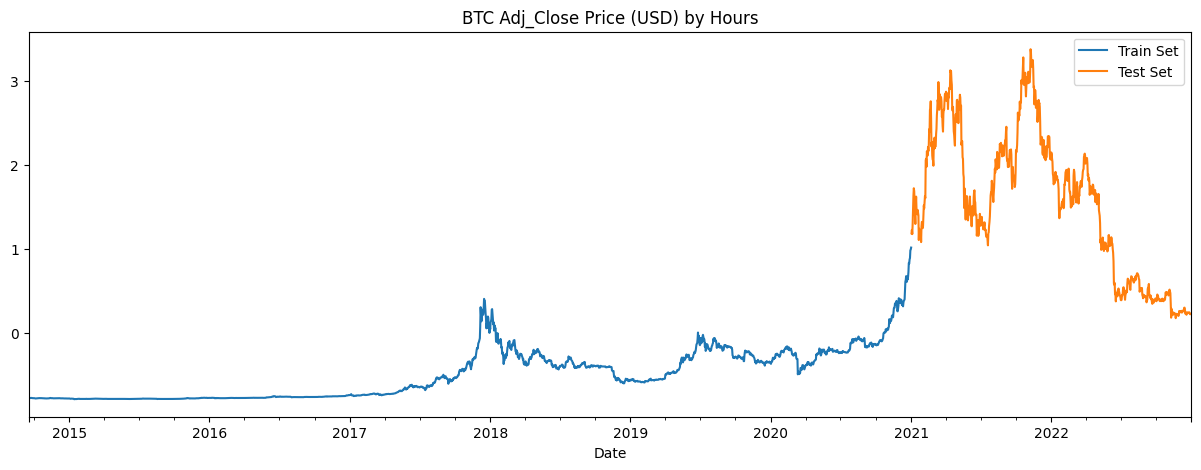

In [42]:
plotting = whole_data.plot(figsize=(15,5), title='BTC Adj_Close Price (USD) by Hours', style='')

# -------------------------------------------------------------------------------------

## <font color= blue >7. Model Construction </font> <a class="anchor" id="fifth-bullet"></a>

## <font color= blue >7.1 Multivariate Time Series Forecasting with LSTM </font> <a class="anchor" id="fifth-bullet"></a>

modelA = Sequential()
modelA.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 5)))
modelA.add(Dropout(0.2))
modelA.add(LSTM(128,activation="tanh", return_sequences=True))
modelA.add(Dropout(0.3))
modelA.add(LSTM(256, activation="tanh",return_sequences=True))
modelA.add(Dropout(0.4))
modelA.add(LSTM(256, activation="tanh",return_sequences=True))
modelA.add(Dropout(0.5))
modelA.add(Dense(1))
modelA.compile(loss='mean_squared_error', optimizer='adam')
historyA=modelA.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)


# RELU RMSE: 2446.116001671878
# TANH RMSE: 3128.1745214528337


modelB = Sequential()
modelB.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 5)))
modelB.add(Dropout(0.2))
modelB.add(LSTM(128,activation="tanh", return_sequences=True))
modelB.add(Dropout(0.3))
modelB.add(LSTM(256, activation="tanh",return_sequences=True))
modelB.add(Dropout(0.4))
modelB.add(Dense(1))
modelB.compile(loss='mean_squared_error', optimizer='adam')
historyB=modelB.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)


# RELU RMSE: 2284.4029808962628
# TANH RMSE: 2733.1184963220276


In [43]:
modelC = Sequential()
modelC.add(LSTM(120,activation="tanh",input_shape=(1,5)))
modelC.add(Dropout(0.2))
modelC.add(Dense(1))
modelC.compile(loss='mean_squared_error', optimizer='adam')
historyC=modelC.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)


# SIGMOID RMSE: 1886.7381878748952
# RELU RMSE: 289.936057021269
# TANH RMSE: 499.30069380076367



Epoch 1/100
46/46 - 6s - loss: 0.1671 - val_loss: 1.5356 - 6s/epoch - 136ms/step
Epoch 2/100
46/46 - 1s - loss: 0.0101 - val_loss: 1.3821 - 1s/epoch - 25ms/step
Epoch 3/100
46/46 - 1s - loss: 0.0070 - val_loss: 1.3043 - 737ms/epoch - 16ms/step
Epoch 4/100
46/46 - 1s - loss: 0.0062 - val_loss: 1.1991 - 750ms/epoch - 16ms/step
Epoch 5/100
46/46 - 1s - loss: 0.0052 - val_loss: 1.0855 - 693ms/epoch - 15ms/step
Epoch 6/100
46/46 - 1s - loss: 0.0042 - val_loss: 0.9690 - 825ms/epoch - 18ms/step
Epoch 7/100
46/46 - 1s - loss: 0.0035 - val_loss: 0.8472 - 865ms/epoch - 19ms/step
Epoch 8/100
46/46 - 1s - loss: 0.0028 - val_loss: 0.7254 - 912ms/epoch - 20ms/step
Epoch 9/100
46/46 - 1s - loss: 0.0023 - val_loss: 0.6113 - 755ms/epoch - 16ms/step
Epoch 10/100
46/46 - 1s - loss: 0.0018 - val_loss: 0.5071 - 761ms/epoch - 17ms/step
Epoch 11/100
46/46 - 1s - loss: 0.0017 - val_loss: 0.4122 - 840ms/epoch - 18ms/step
Epoch 12/100
46/46 - 1s - loss: 0.0014 - val_loss: 0.3453 - 862ms/epoch - 19ms/step
Epoch 

Epoch 97/100
46/46 - 1s - loss: 0.0010 - val_loss: 0.0895 - 809ms/epoch - 18ms/step
Epoch 98/100
46/46 - 1s - loss: 0.0015 - val_loss: 0.0350 - 763ms/epoch - 17ms/step
Epoch 99/100
46/46 - 1s - loss: 8.7274e-04 - val_loss: 0.0723 - 801ms/epoch - 17ms/step
Epoch 100/100
46/46 - 1s - loss: 0.0012 - val_loss: 0.0323 - 724ms/epoch - 16ms/step


In [44]:
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten

modelD = Sequential()
modelD.add(TimeDistributed(Conv1D(64,3, activation='sigmoid'), input_shape=(None, 5, 1)))
modelD.add(TimeDistributed(MaxPooling1D(2)))
modelD.add(TimeDistributed(Flatten()))
modelD.add(TimeDistributed(Dense(64)))
modelD.add(LSTM(128, return_sequences=True))
modelD.add(Dropout(0.2))
modelD.add(Dense(1))
modelD.compile(loss='mean_squared_error', optimizer='adam')
historyD = modelD.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2, validation_data=(X_test,y_test), shuffle=False)


# RELU RMSE: 2714.9333361538015
# TANH RMSE: 2427.3522207959163
# SIGMOID RMSE: 2551.8844809607754

In [45]:
modelC.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               60480     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 60,601
Trainable params: 60,601
Non-trainable params: 0
_________________________________________________________________


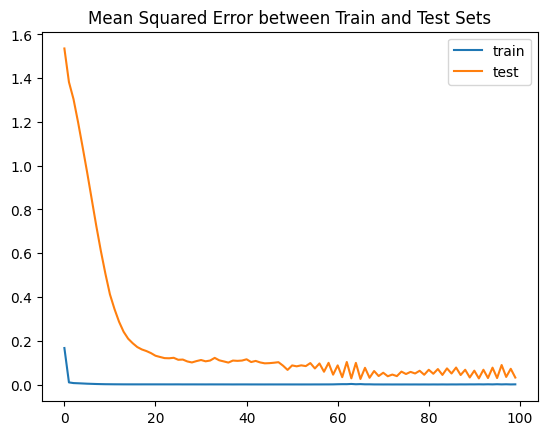

In [46]:
# plot history
import matplotlib.pyplot as pyplot 
pyplot.plot(historyC.history['loss'], label='train')
pyplot.plot(historyC.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [47]:
predicted_BTC_price = modelC.predict(X_test)
predicted_BTC_price

23/23 [==============================] - 1s 8ms/step


array([[1.1760482 ],
       [1.2768124 ],
       [1.2031516 ],
       [1.2726289 ],
       [1.4247016 ],
       [1.5784006 ],
       [1.6518267 ],
       [1.6762041 ],
       [1.5990809 ],
       [1.4019328 ],
       [1.3672348 ],
       [1.4311813 ],
       [1.5832607 ],
       [1.5219568 ],
       [1.4793668 ],
       [1.4299827 ],
       [1.46076   ],
       [1.4799105 ],
       [1.4131583 ],
       [1.2586783 ],
       [1.2141801 ],
       [1.2461244 ],
       [1.2304177 ],
       [1.2746866 ],
       [1.236088  ],
       [1.1683487 ],
       [1.235696  ],
       [1.3674234 ],
       [1.342783  ],
       [1.3030775 ],
       [1.3072923 ],
       [1.3820975 ],
       [1.4845827 ],
       [1.5175228 ],
       [1.5350051 ],
       [1.6186258 ],
       [1.5970162 ],
       [1.8060753 ],
       [1.9692475 ],
       [1.922989  ],
       [1.9794432 ],
       [2.0213468 ],
       [2.0044668 ],
       [2.0505633 ],
       [2.034381  ],
       [2.0736692 ],
       [2.167934  ],
       [2.195

In [48]:
print(predicted_BTC_price.shape)
predicted_BTC_price = predicted_BTC_price.reshape(729,1)
print(predicted_BTC_price.shape)

(729, 1)
(729, 1)


In [49]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
print("Shape of X_test: ", X_test.shape)
X_test

Shape of X_test:  (729, 5)


array([[ 1.02041323,  1.20303057,  1.05651194,  1.19047594,  2.57972766],
       [ 1.19047833,  1.29057745,  1.24502236,  1.23093623,  3.12048313],
       [ 1.23258088,  1.22020343,  1.03305738,  1.18087595,  3.24557204],
       ...,
       [ 0.2281958 ,  0.20896378,  0.25549065,  0.23359318, -0.09371234],
       [ 0.23369431,  0.20846214,  0.24911119,  0.23113649, -0.0207629 ],
       [ 0.23136807,  0.20759227,  0.25605316,  0.22773225, -0.25559383]])

In [50]:
from numpy import concatenate

Bitcoin_pred = concatenate((predicted_BTC_price, X_test[:,:]), axis=1)

Bitcoin_pred = scaler.inverse_transform(Bitcoin_pred)
Bitcoin_pred = Bitcoin_pred[:,0]
Bitcoin_pred

array([31895.81779483, 33526.95389728, 32334.55834728, 33459.23239417,
       35920.93045218, 38408.95564495, 39597.55158135, 39992.16335586,
       38743.72109314, 35552.35828453, 34990.67929473, 36025.82217223,
       38487.62829442, 37495.26339268, 36805.83132057, 36006.41886358,
       36504.63137717, 36814.63276171, 35734.07205504, 33233.40528346,
       32513.08422461, 33030.18674203, 32775.93296401, 33492.54124654,
       32867.72190278, 31771.18120616, 32861.37506219, 34993.73210769,
       34594.86144684, 33952.12274712, 34020.35176592, 35231.27067342,
       36890.26417653, 37423.48755327, 37706.48447224, 39060.1059829 ,
       38710.29838743, 42094.47277142, 44735.84488863, 43987.02962238,
       44900.88976007, 45579.21051928, 45305.96253271, 46052.15724271,
       45790.20196247, 46426.18665122, 47952.11070053, 48400.26441455,
       49917.9061167 , 51121.97259765, 51659.75782636, 50015.26807938,
       47239.10713014, 46812.10697847, 46342.33656992, 39444.93794953,
      

In [51]:
data_test=pd.DataFrame(scaler.inverse_transform(data_test), columns=data_btc.columns, index=test.index)
display(data_test.head())

data_train=pd.DataFrame(scaler.inverse_transform(data_train), columns=data_btc.columns, index=train.index)
display(data_train.head())

data_test['M_LSTM_Pred'] = Bitcoin_pred
mixed_data = pd.concat([data_test, data_train], sort=False)
display(mixed_data.head())

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,6.786542e+10,32127.267578
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,7.866524e+10,32782.023438
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,8.116348e+10,31971.914062
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,6.754732e+10,33992.429688
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,7.528943e+10,36824.363281


,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07,398.821014


,Open,High,Low,Close,Volume,Adj_Close,M_LSTM_Pred
Date,,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,6.786542e+10,32127.267578,31895.817795
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,7.866524e+10,32782.023438,33526.953897
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,8.116348e+10,31971.914062,32334.558347
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,6.754732e+10,33992.429688,33459.232394
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,7.528943e+10,36824.363281,35920.930452


In [52]:
#saving the predicted values in a common data frame for future comparison
final_data = mixed_data
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'M_LSTM_Pred': 'LSTM prediction'})
final_data = final_data[['Date','Adj_Close','LSTM prediction']]

final_data.head()

,Date,Adj_Close,LSTM prediction
0,2021-01-02,32127.267578,31895.817795
1,2021-01-03,32782.023438,33526.953897
2,2021-01-04,31971.914062,32334.558347
3,2021-01-05,33992.429688,33459.232394
4,2021-01-06,36824.363281,35920.930452


<AxesSubplot:title={'center':'Weighted Price vs Weighted Price M_LSTM'}, xlabel='Date'>

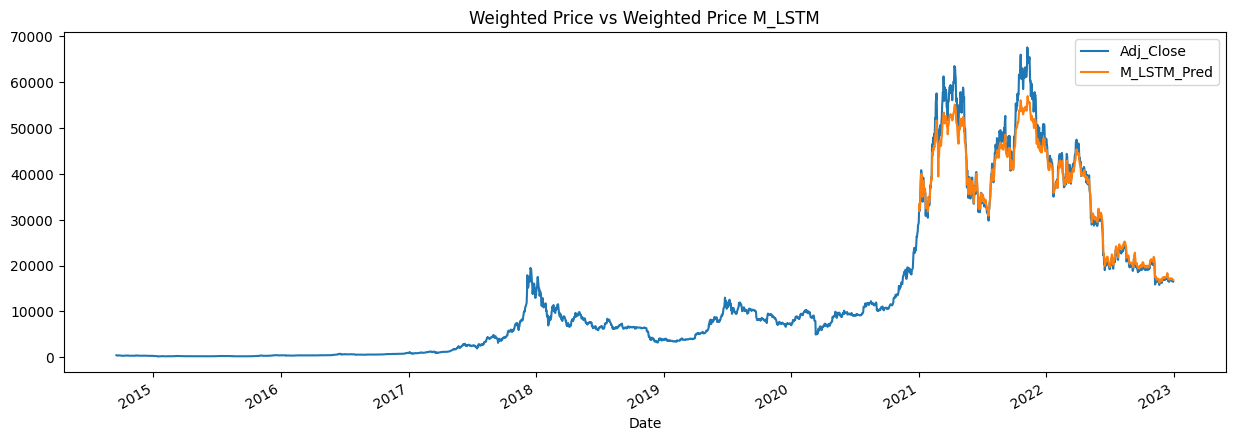

In [53]:
mixed_data[['Adj_Close','M_LSTM_Pred']].plot(figsize=(15, 5),title=('Weighted Price vs Weighted Price M_LSTM'))

In [54]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 
from sklearn.metrics import mean_absolute_error

In [55]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Adj_Close'],
                   y_pred=data_test['M_LSTM_Pred']))
print('RMSE:',rmse)


print('Mean Absolute Error',mean_absolute_error(y_true=data_test['Adj_Close'],
                   y_pred=data_test['M_LSTM_Pred']))

print('R2_Score', r2_score(data_test['Adj_Close'], data_test['M_LSTM_Pred']))

RMSE: 2902.7604912708844
Mean Absolute Error 1872.5159728110104
R2_Score 0.9561891784944961


# -------------------------------------------------------------------------------------

## <font color= blue >7.2 Univariate Time Series with LSTM </font> <a class="anchor" id="fifth-bullet"></a>

Preparing the data to train and validate the the Univariate Time Series Model

In [56]:
only_train=train.to_numpy()
only_test=test.to_numpy()

In [57]:
only_train1=only_train[0:len(only_train)-1]
only_test1=only_test[0:len(only_test)-1]

only_y_train=only_train[1:len(only_train)]
only_y_test=only_test[1:len(only_test)]

In [58]:
len(only_train1)

2298

In [59]:
print(only_train1.shape, only_y_train.shape, only_test1.shape, only_y_test.shape)

(2298, 1) (2298, 1) (728, 1) (728, 1)


In [60]:
len(only_train[1:len(only_train)])

2298

In [61]:
only_train1 = only_train1.reshape((only_train1.shape[0], 1, only_train1.shape[1]))
only_test1 = only_test1.reshape((only_test1.shape[0], 1, only_test1.shape[1]))
print(only_train1.shape, only_y_train.shape, only_test1.shape, only_y_test.shape)

(2298, 1, 1) (2298, 1) (728, 1, 1) (728, 1)


In [62]:
only_train.shape

(2299, 1)

In [63]:
only_y_train=only_y_train.reshape((only_y_train.shape[0],only_y_train.shape[1]))

In [64]:
only_y_test = only_y_test.reshape((only_y_test.shape[0], only_y_test.shape[1]))

In [65]:
print(only_train1.shape, only_y_train.shape)

(2298, 1, 1) (2298, 1)


In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

uni_modelA = Sequential()
uni_modelA.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 5)))
uni_modelA.add(Dropout(0.2))
uni_modelA.add(LSTM(128,activation="tanh", return_sequences=True))
uni_modelA.add(Dropout(0.3))
uni_modelA.add(LSTM(256, activation="tanh",return_sequences=True))
uni_modelA.add(Dropout(0.4))
uni_modelA.add(LSTM(256, activation="tanh",return_sequences=True))
uni_modelA.add(Dropout(0.5))
uni_modelA.add(Dense(1))
uni_modelA.compile(loss='mean_squared_error', optimizer='adam')
uni_historyA=uni_modelA.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)


# RELU RMSE: 
# TANH RMSE: 


uni_modelB = Sequential()
uni_modelB.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 1)))
uni_modelB.add(Dropout(0.2))
uni_modelB.add(LSTM(128,activation="tanh", return_sequences=True))
uni_modelB.add(Dropout(0.3))
uni_modelB.add(LSTM(256, activation="tanh",return_sequences=True))
uni_modelB.add(Dropout(0.4))
uni_modelB.add(Dense(1))
uni_modelB.compile(loss='mean_squared_error', optimizer='adam')
uni_historyB=uni_modelB.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)


# RELU RMSE: 
# TANH RMSE: 


uni_modelC = Sequential()
uni_modelC.add(TimeDistributed(Conv1D(64,3, activation='sigmoid'), input_shape=(None, 5, 1)))
uni_modelC.add(TimeDistributed(MaxPooling1D(2)))
uni_modelC.add(TimeDistributed(Flatten()))
uni_modelC.add(TimeDistributed(Dense(64)))
uni_modelC.add(LSTM(128, return_sequences=True))
uni_modelC.add(Dropout(0.2))
uni_modelC.add(Dense(1))
uni_modelC.compile(loss='mean_squared_error', optimizer='adam')
uni_historyC = uni_modelC.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2, validation_data=(X_test,y_test), shuffle=False)


# RELU RMSE: 
# TANH RMSE: 
# SIGMOID RMSE: 

In [67]:
uni_modelD = Sequential()
uni_modelD.add(LSTM(120,activation="tanh",input_shape=(1,1)))
uni_modelD.add(Dropout(0.2))
uni_modelD.add(Dense(1))
uni_modelD.compile(loss='mean_squared_error', optimizer='adam')  
uni_historyD=uni_modelD.fit(only_train1, only_y_train, epochs=100, batch_size=50, verbose=2, validation_data=(only_test1, only_y_test), shuffle=False)

# SIGMOID RMSE: 7610.902184874228
# RELU RMSE: 9798.85878473915
# TAHN RMSE: 1418.8478880164055


Epoch 1/100
46/46 - 6s - loss: 0.2386 - val_loss: 2.7240 - 6s/epoch - 123ms/step
Epoch 2/100
46/46 - 1s - loss: 0.0869 - val_loss: 2.3121 - 908ms/epoch - 20ms/step
Epoch 3/100
46/46 - 1s - loss: 0.0382 - val_loss: 2.0061 - 950ms/epoch - 21ms/step
Epoch 4/100
46/46 - 1s - loss: 0.0278 - val_loss: 1.7497 - 906ms/epoch - 20ms/step
Epoch 5/100
46/46 - 1s - loss: 0.0217 - val_loss: 1.5154 - 891ms/epoch - 19ms/step
Epoch 6/100
46/46 - 1s - loss: 0.0158 - val_loss: 1.3115 - 816ms/epoch - 18ms/step
Epoch 7/100
46/46 - 1s - loss: 0.0110 - val_loss: 1.1354 - 909ms/epoch - 20ms/step
Epoch 8/100
46/46 - 1s - loss: 0.0075 - val_loss: 0.9839 - 825ms/epoch - 18ms/step
Epoch 9/100
46/46 - 1s - loss: 0.0050 - val_loss: 0.8582 - 720ms/epoch - 16ms/step
Epoch 10/100
46/46 - 1s - loss: 0.0033 - val_loss: 0.7593 - 822ms/epoch - 18ms/step
Epoch 11/100
46/46 - 1s - loss: 0.0023 - val_loss: 0.6823 - 786ms/epoch - 17ms/step
Epoch 12/100
46/46 - 1s - loss: 0.0019 - val_loss: 0.6278 - 831ms/epoch - 18ms/step
Epo

Epoch 98/100
46/46 - 1s - loss: 9.3142e-04 - val_loss: 0.0141 - 734ms/epoch - 16ms/step
Epoch 99/100
46/46 - 1s - loss: 9.2009e-04 - val_loss: 0.0133 - 663ms/epoch - 14ms/step
Epoch 100/100
46/46 - 1s - loss: 9.3055e-04 - val_loss: 0.0137 - 625ms/epoch - 14ms/step


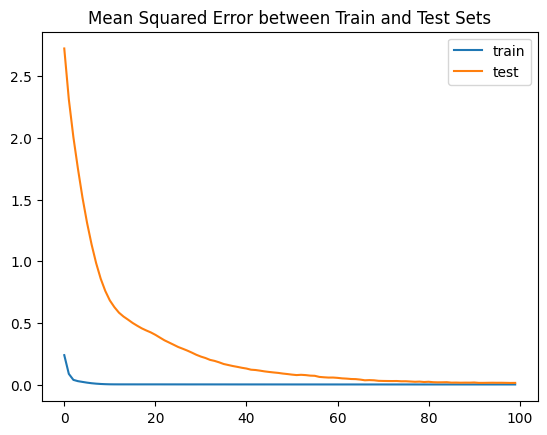

In [68]:
import matplotlib.pyplot as pyplot 
pyplot.plot(uni_historyD.history['loss'], label='train')
pyplot.plot(uni_historyD.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [69]:
uni_predicted_BTC_price = uni_modelD.predict(only_test.reshape(only_test.shape[0],1,1))
uni_predicted_BTC_price

23/23 [==============================] - 1s 7ms/step


array([[1.1945963 ],
       [1.2341735 ],
       [1.1851888 ],
       [1.3070217 ],
       [1.475712  ],
       [1.6250873 ],
       [1.7077096 ],
       [1.67635   ],
       [1.565856  ],
       [1.401111  ],
       [1.3028523 ],
       [1.5047497 ],
       [1.6143907 ],
       [1.4757712 ],
       [1.4374468 ],
       [1.4144725 ],
       [1.4642222 ],
       [1.4310179 ],
       [1.3999856 ],
       [1.1155876 ],
       [1.2476708 ],
       [1.1909864 ],
       [1.2044061 ],
       [1.2090639 ],
       [1.2213612 ],
       [1.0916392 ],
       [1.2753962 ],
       [1.3264463 ],
       [1.3236384 ],
       [1.2542169 ],
       [1.2796718 ],
       [1.3977551 ],
       [1.5139235 ],
       [1.4817213 ],
       [1.5534242 ],
       [1.6189735 ],
       [1.5978365 ],
       [2.0128295 ],
       [2.0285625 ],
       [1.9417233 ],
       [2.106943  ],
       [2.0848415 ],
       [2.0629463 ],
       [2.1508608 ],
       [2.1088917 ],
       [2.1769445 ],
       [2.3338866 ],
       [2.309

In [70]:
X_test.shape

(729, 5)

In [71]:
data_test['M_LSTM_Pred'] = Bitcoin_pred
mixed_data = pd.concat([data_test, data_train], sort=False)

In [72]:
Bitcoin_pred_uni = concatenate((uni_predicted_BTC_price, X_test), axis=1)
Bitcoin_pred_uni = scaler.inverse_transform(Bitcoin_pred_uni)
Bitcoin_pred_uni[:,0]

array([32196.06831725, 32836.73064103, 32043.78273739, 34015.97130737,
       36746.66811421, 39164.70245618, 40502.16258345, 39994.52532998,
       38205.88762149, 35539.05481264, 33948.47751092, 37216.7202615 ,
       38991.55084186, 36747.62718376, 36127.24619007, 35755.34525987,
       36560.67616018, 36023.17652965, 35520.83635049, 30917.10371411,
       33055.21903639, 32137.63261436, 32354.86669341, 32430.26461241,
       32629.32847224, 30529.43506288, 33504.02885434, 34330.40911226,
       34284.95654817, 33161.18560904, 33573.2400993 , 35484.73133757,
       37365.22359522, 36843.94516931, 38004.64704041, 39065.73496861,
       38723.576773  , 45441.33606911, 45696.01631467, 44290.29436341,
       46964.8093773 , 46607.03976776, 46252.60856935, 47675.73657174,
       46996.35639767, 48097.97032139, 50638.49347655, 50238.93004714,
       53758.10167263, 53930.98891566, 55099.05458843, 52370.07908954,
       47769.63276193, 48538.27780438, 46242.23440851, 45569.62368314,
      

In [73]:
data_test['Uni_LSTM_Pred']=Bitcoin_pred_uni[:,0]
data_test.head()

,Open,High,Low,Close,Volume,Adj_Close,M_LSTM_Pred,Uni_LSTM_Pred
Date,,,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,6.786542e+10,32127.267578,31895.817795,32196.068317
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,7.866524e+10,32782.023438,33526.953897,32836.730641
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,8.116348e+10,31971.914062,32334.558347,32043.782737
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,6.754732e+10,33992.429688,33459.232394,34015.971307
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,7.528943e+10,36824.363281,35920.930452,36746.668114


In [74]:
mixed_data2 = pd.concat([data_test, data_train], sort=False)
mixed_data2.head()

,Open,High,Low,Close,Volume,Adj_Close,M_LSTM_Pred,Uni_LSTM_Pred
Date,,,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,6.786542e+10,32127.267578,31895.817795,32196.068317
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,7.866524e+10,32782.023438,33526.953897,32836.730641
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,8.116348e+10,31971.914062,32334.558347,32043.782737
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,6.754732e+10,33992.429688,33459.232394,34015.971307
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,7.528943e+10,36824.363281,35920.930452,36746.668114


<AxesSubplot:title={'center':'Actual Weighted Price vs Weighted Price U_LSTM'}, xlabel='Date'>

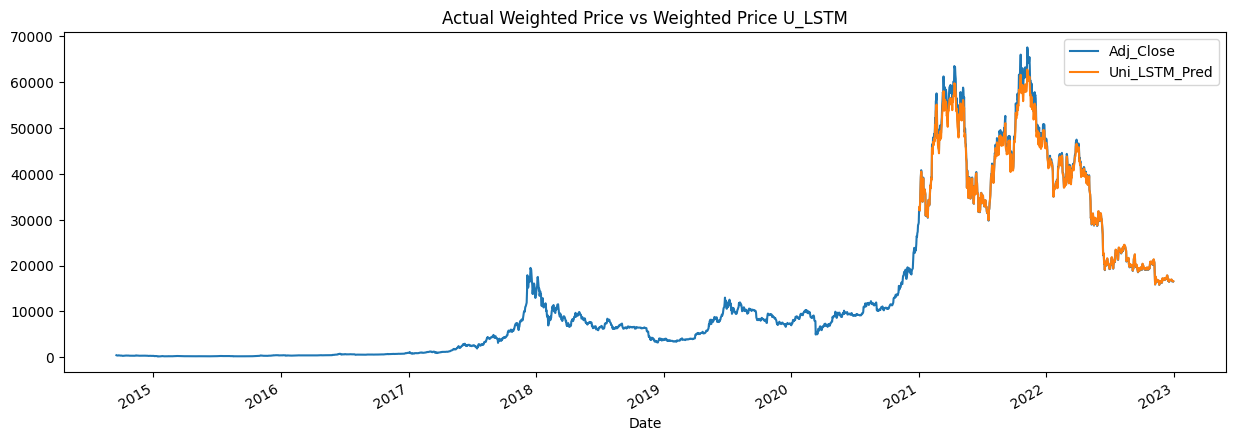

In [75]:
mixed_data2[['Adj_Close','Uni_LSTM_Pred']].plot(figsize=(15, 5),title=('Actual Weighted Price vs Weighted Price U_LSTM'))

In [76]:
mixed_data2=mixed_data2.reset_index()

In [77]:
final_data['Uni_LSTM_Pred']=mixed_data2['Uni_LSTM_Pred']
final_data

,Date,Adj_Close,LSTM prediction,Uni_LSTM_Pred
0,2021-01-02,32127.267578,31895.817795,32196.068317
1,2021-01-03,32782.023438,33526.953897,32836.730641
2,2021-01-04,31971.914062,32334.558347,32043.782737
3,2021-01-05,33992.429688,33459.232394,34015.971307
4,2021-01-06,36824.363281,35920.930452,36746.668114
...,...,...,...,...
3023,2020-12-28,27084.808594,NaN,NaN
3024,2020-12-29,27362.437500,NaN,NaN
3025,2020-12-30,28840.953125,NaN,NaN
3026,2020-12-31,29001.720703,NaN,NaN


In [78]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Adj_Close'],
                   y_pred=data_test['Uni_LSTM_Pred']))
print('RMSE:',rmse)

print("Mean Absolute Error: ", mean_absolute_error(y_true=data_test['Adj_Close'],
                   y_pred=data_test['Uni_LSTM_Pred']))

print("R2 Score: ", r2_score(data_test['Adj_Close'], data_test['Uni_LSTM_Pred']))

RMSE: 1226.9781604020131
Mean Absolute Error:  716.3344912012994
R2 Score:  0.9921723273530628


# -------------------------------------------------------------------------------------

## <font color= blue >7.3 Time Series Forecasting with FacebookProphet </font> <a class="anchor" id="fifth-bullet"></a>

__Prophet__ is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. <br>

It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. <br>


__Data does not need to be normalized, Prophet will actually internally scale y before fitting the model__<br>

In [79]:
# In anaconda prompt
# conda install libpython m2w64-toolchain -c msys2
# pip install pystan
# pip install fbprophet

In [80]:
df_day.tail()

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,1.574858e+10,16717.173828
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,1.700571e+10,16552.572266
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,16642.341797
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,1.592916e+10,16602.585938
2022-12-31,16603.673828,16628.986328,16517.519531,16547.496094,1.123919e+10,16547.496094


In [81]:
#Facebook Prophet packages:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [82]:
# Renaming the column names accroding to Prophet's requirements
prophet_df = df_day.reset_index()[['Date','Adj_Close']]
prophet_df.rename(columns={'Date':'ds','Adj_Close':'y'},inplace=True)

In [83]:
# Basic model 
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

22:11:03 - cmdstanpy - INFO - Chain [1] start processing
22:11:06 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# Making predictions for 1 year, until 2022-01-01
future= prophet_basic.make_future_dataframe(periods=365)#Making predictions for one year
future.tail(1)

,ds
3392,2023-12-31


In [85]:
forecast = prophet_basic.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3388,2023-12-27,-4966.406647,-16705.042614,9712.357000,-16674.373081,7051.560885,1292.110496,1292.110496,1292.110496,23.625221,23.625221,23.625221,1268.485276,1268.485276,1268.485276,0.0,0.0,0.0,-3674.296150
3389,2023-12-28,-5028.364908,-16289.597420,10083.076765,-16794.369110,7082.683662,1341.065270,1341.065270,1341.065270,-18.603709,-18.603709,-18.603709,1359.668979,1359.668979,1359.668979,0.0,0.0,0.0,-3687.299638
3390,2023-12-29,-5090.323170,-16759.641009,9655.109364,-16943.502924,7120.045489,1435.372496,1435.372496,1435.372496,-11.748666,-11.748666,-11.748666,1447.121163,1447.121163,1447.121163,0.0,0.0,0.0,-3654.950674
3391,2023-12-30,-5152.281432,-15798.000149,10914.995727,-17055.988211,7163.466620,1533.399165,1533.399165,1533.399165,4.564386,4.564386,4.564386,1528.834778,1528.834778,1528.834778,0.0,0.0,0.0,-3618.882267
3392,2023-12-31,-5214.239693,-17207.408189,9898.678350,-17150.973226,7199.082619,1601.787935,1601.787935,1601.787935,-1.052261,-1.052261,-1.052261,1602.840196,1602.840196,1602.840196,0.0,0.0,0.0,-3612.451758


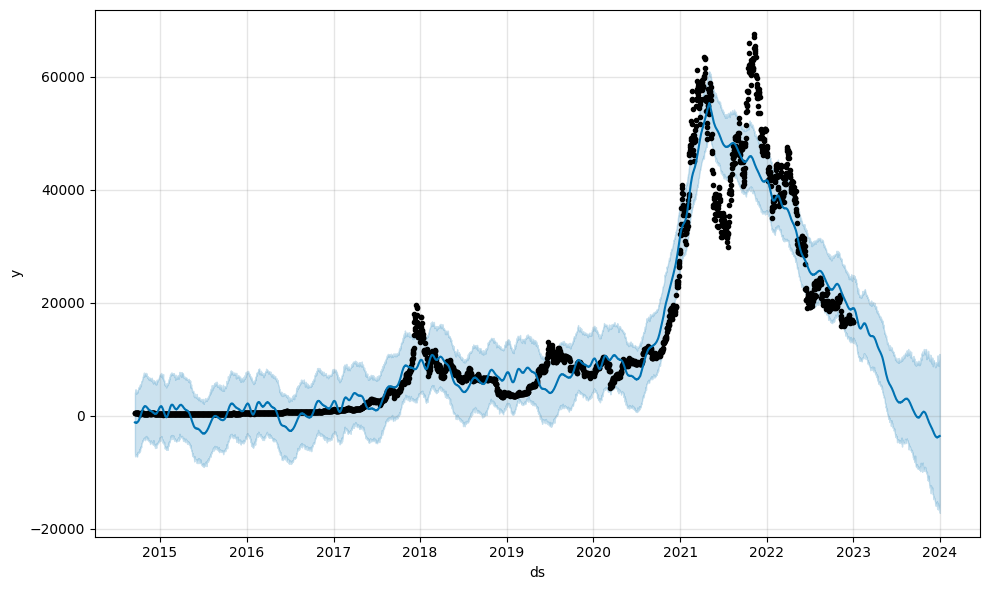

In [86]:
fig = prophet_basic.plot(forecast)

__Adding ChangePoints to Prophet__<br>
Changepoints are the datetime points where the time series have abrupt changes in the trajectory.<br>
By default, Prophet adds 25 changepoints to the initial 80% of the data-set.

Change points:  {prophet_basic.changepoints}



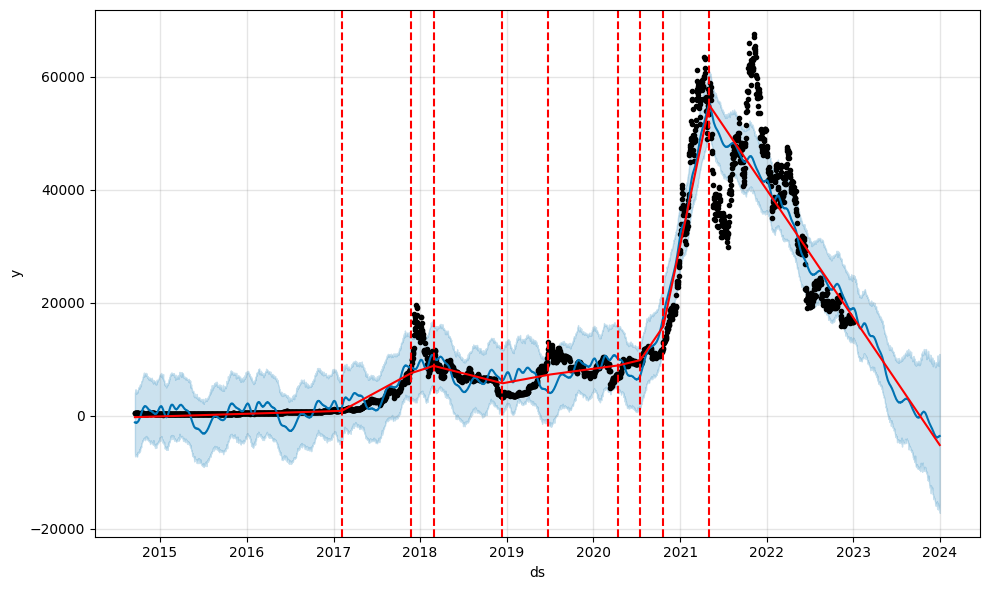

In [87]:
fig_1 = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig_1.gca(), prophet_basic, forecast)

print('Change points: ','{prophet_basic.changepoints}\n')

In [88]:
print('Change points:\n\n',prophet_basic.changepoints)

Change points:

 97     2014-12-23
194    2015-03-30
291    2015-07-05
387    2015-10-09
484    2016-01-14
581    2016-04-20
678    2016-07-26
775    2016-10-31
872    2017-02-05
968    2017-05-12
1065   2017-08-17
1162   2017-11-22
1259   2018-02-27
1356   2018-06-04
1453   2018-09-09
1549   2018-12-14
1646   2019-03-21
1743   2019-06-26
1840   2019-10-01
1937   2020-01-06
2034   2020-04-12
2130   2020-07-17
2227   2020-10-22
2324   2021-01-27
2421   2021-05-04
Name: ds, dtype: datetime64[ns]


__Adding Multiple Regressors__ <br>
Additional regressors can be added to the Prophet model. This is done by using add_regressor. <br>
Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.


In [89]:
prophet_df['Open'] = df_day.reset_index()['Open']
prophet_df['High'] = df_day.reset_index()['High']
prophet_df['Low'] = df_day.reset_index()['Low']
prophet_df['Close'] = df_day.reset_index()['Close']
prophet_df['Volume'] = df_day.reset_index()['Volume']

In [90]:
prophet_df.head()

,ds,y,Open,High,Low,Close,Volume
0,2014-09-17,457.334015,465.864014,468.174011,452.421997,457.334015,21056800.0
1,2014-09-18,424.440002,456.859985,456.859985,413.104004,424.440002,34483200.0
2,2014-09-19,394.795990,424.102997,427.834991,384.532013,394.795990,37919700.0
3,2014-09-20,408.903992,394.673004,423.295990,389.882996,408.903992,36863600.0
4,2014-09-21,398.821014,408.084991,412.425995,393.181000,398.821014,26580100.0


In [91]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Close')
pro_regressor.add_regressor('Volume')

splitter= '2019-01-01'
train_X = prophet_df.loc[prophet_df.ds <= splitter]
test_X = prophet_df.loc[prophet_df.ds > splitter]

In [92]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=365)

22:11:10 - cmdstanpy - INFO - Chain [1] start processing
22:11:13 - cmdstanpy - INFO - Chain [1] done processing


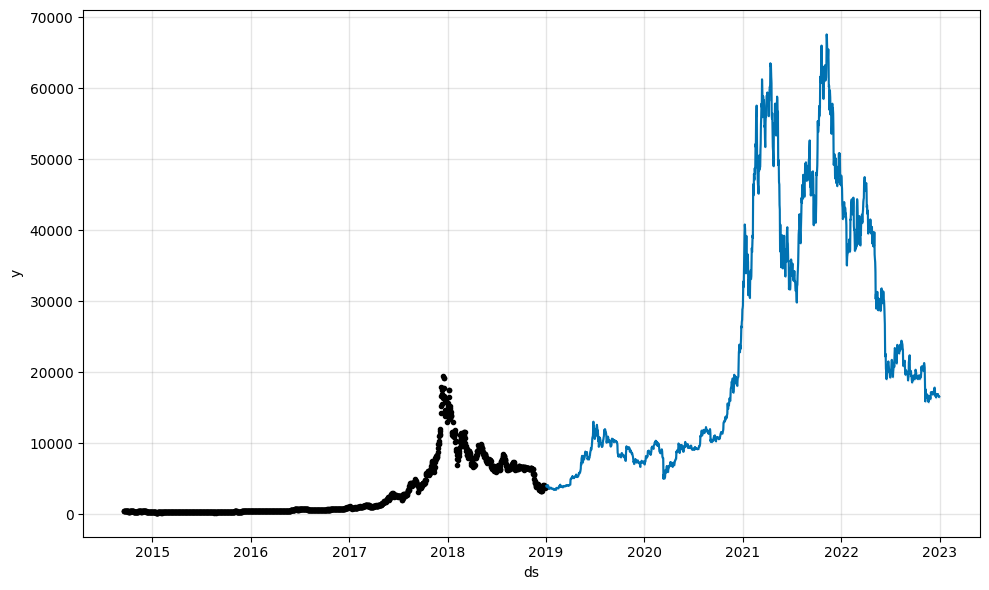

In [93]:
#Forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

In [94]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

22:11:15 - cmdstanpy - INFO - Chain [1] start processing
22:11:16 - cmdstanpy - INFO - Chain [1] done processing
22:11:17 - cmdstanpy - INFO - Chain [1] start processing
22:11:18 - cmdstanpy - INFO - Chain [1] done processing
22:11:18 - cmdstanpy - INFO - Chain [1] start processing
22:11:20 - cmdstanpy - INFO - Chain [1] done processing
22:11:21 - cmdstanpy - INFO - Chain [1] start processing
22:11:23 - cmdstanpy - INFO - Chain [1] done processing
22:11:23 - cmdstanpy - INFO - Chain [1] start processing
22:11:26 - cmdstanpy - INFO - Chain [1] done processing
22:11:27 - cmdstanpy - INFO - Chain [1] start processing
22:11:30 - cmdstanpy - INFO - Chain [1] done processing
22:11:31 - cmdstanpy - INFO - Chain [1] start processing
22:11:34 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,655.519998,25.603125,8.567650,0.034312,0.000106,0.041860,0.712045
1,38 days,768.406867,27.720153,9.377489,0.037688,0.000112,0.046733,0.708123
2,39 days,893.991140,29.899685,10.231209,0.041311,0.000112,0.052105,0.702521
3,40 days,1032.480993,32.132242,11.126722,0.045078,0.000130,0.057871,0.702521
4,41 days,1183.997865,34.409270,12.059916,0.048773,0.000157,0.063443,0.702521


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,63474.374733,251.941213,100.121434,0.219674,0.001756,0.288709,0.857143
325,362 days,63474.030964,251.940531,100.128354,0.219470,0.001772,0.288703,0.857143
326,363 days,63473.685193,251.939844,100.135424,0.220360,0.001791,0.288698,0.857143
327,364 days,63473.346364,251.939172,100.141393,0.221097,0.001788,0.288692,0.857143
328,365 days,63473.203505,251.938888,100.150821,0.222015,0.001788,0.288687,0.857143


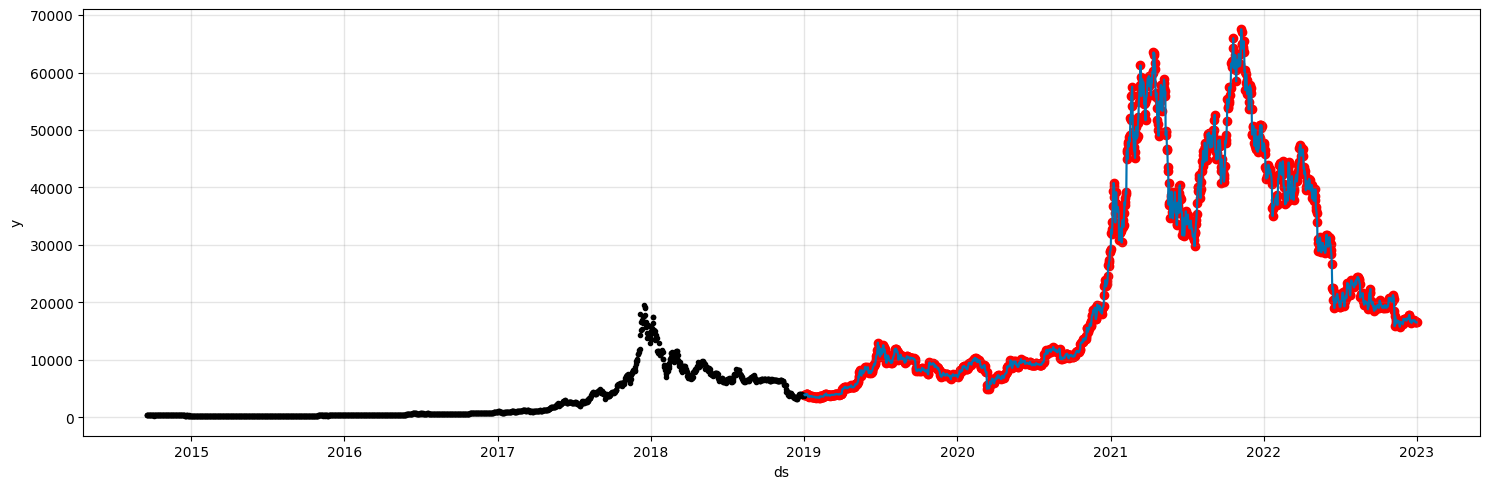

In [95]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_X.ds, test_X.y, color='r')
fig = pro_regressor.plot(forecast_data, ax=ax)

In [96]:
 from prophet.utilities import regressor_coefficients

In [97]:
regressor_coefficients(pro_regressor)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Open,additive,2.916459e+03,1.637004e-04,1.637004e-04,1.637004e-04
1,High,additive,3.004184e+03,-5.103212e-04,-5.103212e-04,-5.103212e-04
2,Low,additive,2.817755e+03,5.613984e-04,5.613984e-04,5.613984e-04
3,Close,additive,2.918367e+03,9.998467e-01,9.998467e-01,9.998467e-01
4,Volume,additive,1.998481e+09,-3.304655e-11,-3.304655e-11,-3.304655e-11


In [98]:
#for comparision of predictions
forecast_data = forecast_data.rename(columns={'ds': 'Date'})
forecast_data = forecast_data.rename(columns={'yhat': 'prophet'})
test_X = test_X.rename(columns={'ds': 'Date'})
test_X = test_X.rename(columns={'y': 'Adj_Close'})

data_compare = pd.merge(test_X, forecast_data, on='Date')
data_compare = data_compare[['Date','Adj_Close','prophet']]
data_compare = data_compare.set_index('Date')
data_compare.head()

,Adj_Close,prophet
Date,,
2019-01-02,3943.409424,3943.391199
2019-01-03,3836.741211,3836.777151
2019-01-04,3857.717529,3857.720283
2019-01-05,3845.194580,3845.174198
2019-01-06,4076.632568,4076.445069


In [99]:
data_compare.tail()

,Adj_Close,prophet
Date,,
2022-12-27,16717.173828,16712.945724
2022-12-28,16552.572266,16548.314842
2022-12-29,16642.341797,16638.182004
2022-12-30,16602.585938,16598.330819
2022-12-31,16547.496094,16543.437391


In [100]:
rmse=math.sqrt(mean_squared_error(y_true=data_compare['Adj_Close'],
                   y_pred=data_compare['prophet']))
print('RMSE:',rmse)

RMSE: 3.503755832995398


In [101]:
mean_absolute_error(y_true=data_compare['Adj_Close'],
                   y_pred=data_compare['prophet'])

3.153791239966535

In [102]:
r2_score(data_compare['Adj_Close'], data_compare['prophet'])

0.9999999601370635

22:11:37 - cmdstanpy - INFO - Chain [1] start processing
22:11:39 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,Delta
3388,2023-12-27,-3674.296150,-16334.970029,10520.867873,-155.262572
3389,2023-12-28,-3687.299638,-16332.496031,11075.703702,-147.462378
3390,2023-12-29,-3654.950674,-16373.346129,11495.065769,-142.438038
3391,2023-12-30,-3618.882267,-16026.111081,11682.670269,-137.178494
3392,2023-12-31,-3612.451758,-16440.541007,11467.041821,-143.372120


,ds,yhat_lower,yhat_upper,weekly_lower,weekly_upper,yhat,Real
3388,2023-12-27,-16334.970029,10520.867873,23.625221,23.625221,-3674.296150,NaN
3389,2023-12-28,-16332.496031,11075.703702,-18.603709,-18.603709,-3687.299638,NaN
3390,2023-12-29,-16373.346129,11495.065769,-11.748666,-11.748666,-3654.950674,NaN
3391,2023-12-30,-16026.111081,11682.670269,4.564386,4.564386,-3618.882267,NaN
3392,2023-12-31,-16440.541007,11467.041821,-1.052261,-1.052261,-3612.451758,NaN


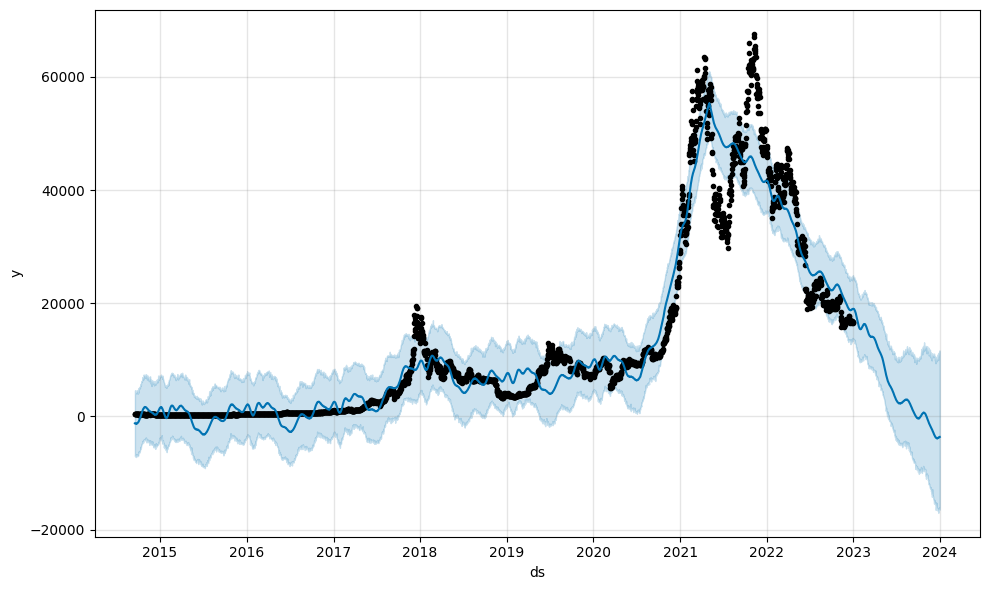

In [103]:
# Renaming the column names accroding to Prophet's requirements
prophet_df = df_day.reset_index()[['Date','Adj_Close']]
prophet_df.rename(columns={'Date':'ds','Adj_Close':'y'},inplace=True)
prophet_df.tail()

pro_regressor = Prophet()
pro_regressor.fit(prophet_df)

# Python
future = pro_regressor.make_future_dataframe(periods=365)
future.tail()

# Python
forecast = pro_regressor.predict(future)
forecast['Delta'] = (forecast['yhat_lower']/forecast['yhat_upper'])*100
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','Delta']].tail())

# Python
fig1 = pro_regressor.plot(forecast)


csv = forecast[['ds', 'yhat_lower', 'yhat_upper', 'weekly_lower', 'weekly_upper', 'yhat']]
csv['Real'] = df_day.reset_index()['Close']
display(csv.tail())
print("\n")


from pathlib import Path  
filepath = Path('bitcoin_2023_prediction_next.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
csv.to_csv(filepath)  

# -------------------------------------------------------------------------------------

## <font color= blue >7.4 Time Series Forecasting with ARIMAX </font> <a class="anchor" id="fifth-bullet"></a>

__pmdarima package: project description__ https://pypi.org/project/pmdarima/#description

For this model we will be using Auto ARIMA functionality in python using the pmdarima package. <br>

In Auto ARIMA function itself operates a bit like a grid search. The model itself will generate the optimal p, d, and q parameters which would be best suitable for the data set to provide better forecasting.

In [121]:
df_day

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,1.574858e+10,16717.173828
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,1.700571e+10,16552.572266
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,16642.341797


In [122]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3028 entries, 2014-09-17 to 2022-12-31
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3028 non-null   float64
 1   High       3028 non-null   float64
 2   Low        3028 non-null   float64
 3   Close      3028 non-null   float64
 4   Volume     3028 non-null   float64
 5   Adj_Close  3028 non-null   float64
dtypes: float64(6)
memory usage: 165.6 KB


In [133]:
teste = df_day.copy()
teste = teste.reset_index()

In [134]:
# Load the data into a Pandas dataframe
df = teste.copy()
df['Date'] = pd.to_datetime(teste['Date'])
df = df.set_index('Date')

# Calculate the first difference of the Adj_Close column
df['Adj_Close_diff'] = df['Adj_Close'] - df['Adj_Close'].shift(1)
df = df.dropna()

# Check if the transformed data is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Adj_Close_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.185665
p-value: 0.000000


In [140]:
df.head()

,Open,High,Low,Close,Volume,Adj_Close,Adj_Close_diff
Date,,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,424.440002,-32.894012
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,394.795990,-29.644012
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,408.903992,14.108002
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,398.821014,-10.082977
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,402.152008,3.330994


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings

from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd

In [147]:
df_train = df[:int(df.shape[0] * 0.8)]
df_test = df[int(df.shape[0] * 0.8):]

In [151]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMA: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMA: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMA: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMA: {} x {}".format(pdq[2], seasonal_pdq[4]))

min_aic = np.inf
best_cfg = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train["Adj_Close"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < min_aic:
                min_aic = results.aic
                best_cfg = (param, param_seasonal)
        except:
            continue

print("Best SARIMA Configuration: {} with AIC: {}".format(best_cfg, min_aic))

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)
Best SARIMA Configuration: ((0, 1, 1), (1, 1, 1, 12)) with AIC: 37071.521146503255


In [149]:
from pmdarima.arima import auto_arima

model = auto_arima(df["Adj_Close_diff"], error_action='ignore', suppress_warnings=True, 
                   stepwise=True, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=49003.773, Time=2.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49023.243, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49023.269, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=49023.289, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=49024.746, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=49027.223, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=49005.761, Time=2.97 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=49005.827, Time=2.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=49025.255, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=49025.611, Time=0.78 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=49025.732, Time=0.66 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=49005.392, Time=2.16 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=49005.652, Time=4.46 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 16.858 seconds


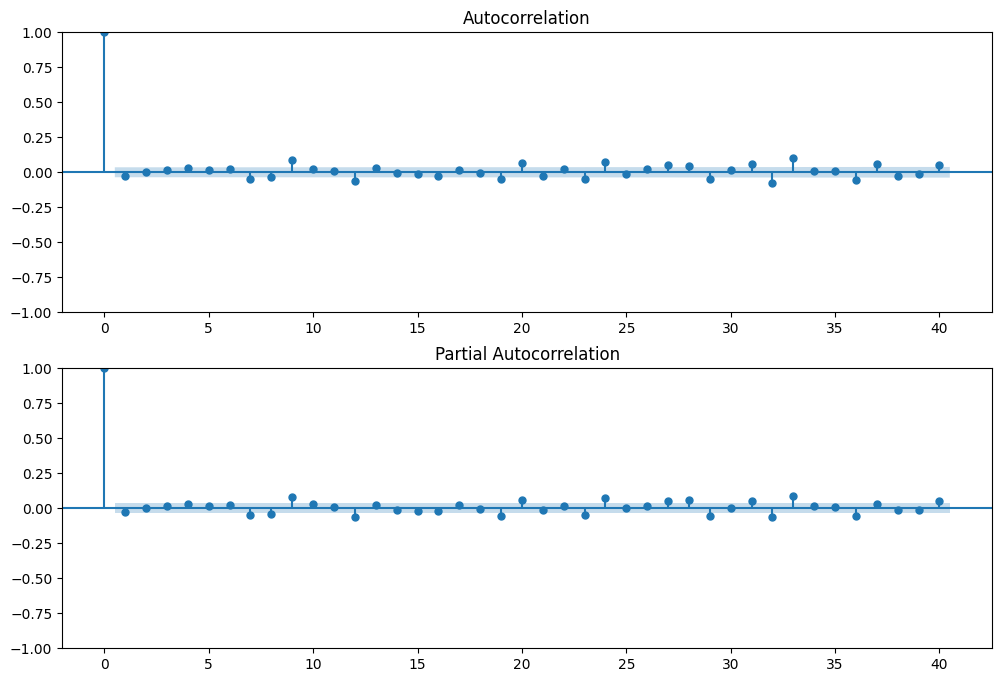

In [150]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["Adj_Close_diff"], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["Adj_Close_diff"], lags=40, ax=ax2)

In [152]:
model = ARIMA(df_train["Adj_Close_diff"], order=(0, 1, 1))
model_fit = model.fit()

In [154]:
predictions = model_fit.predict(start=df_test.index[0], end=df_test.index[-1], typ='levels')

Mean Squared Error: 1981321.8791489452


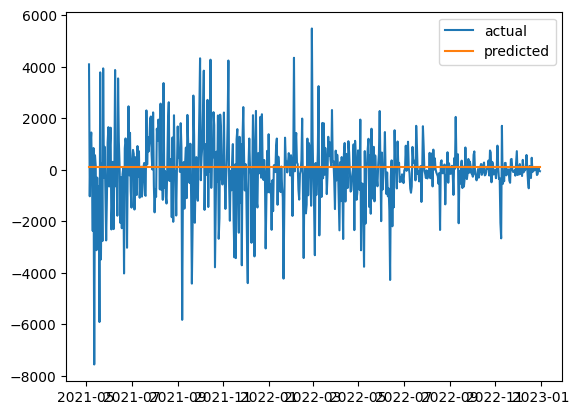

In [156]:
# Make predictions
predictions = model_fit.predict(start=df_train.shape[0], end=df.shape[0]-1, typ='levels')

# Calculate the mean squared error
mse = mean_squared_error(df_test['Adj_Close_diff'], predictions)
print("Mean Squared Error:", mse)

 

In [157]:
gangster_shit = df_day.copy()
gangster_shit

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,1.574858e+10,16717.173828
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,1.700571e+10,16552.572266
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,16642.341797


In [163]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Train and validation split
split = int(len(df_train) * 0.7)
X_train, X_val = df_train[:split], df_train[split:]
y_train, y_val = df_train["Adj_Close"][:split], df_train["Adj_Close"][split:]

# Train the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {
    "objective": "reg:squarederror",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 10,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "silent": 1
}
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on validation set
y_pred = model.predict(dval)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("RMSE:", rmse)

[23:31:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSE: 100.73813234158185


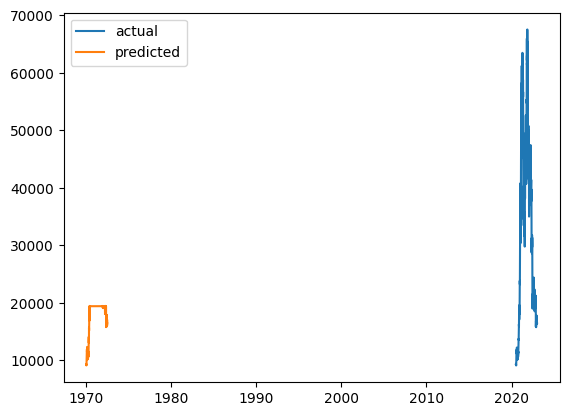

In [165]:
# Train the XGBoost model on the training data
model = xgb.XGBRegressor()
model.fit(df_train.drop('Adj_Close', axis=1), df_train['Adj_Close'])

# Make predictions on the test data
predictions = model.predict(df_test.drop('Adj_Close', axis=1))

# Plot the actual and predicted values
plt.plot(df_test['Adj_Close'], label='actual')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()


In [166]:
!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 1.3 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\migue\anaconda3\envs\tensorflow\python.exe -m pip install --upgrade pip' command.


In [169]:
df

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,1.574858e+10,16717.173828
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,1.700571e+10,16552.572266
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,16642.341797


In [167]:
df = df_day.copy()

In [171]:
df_test

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2020-07-06,9072.849609,9375.474609,9058.664062,9375.474609,1.788926e+10,9375.474609
2020-07-07,9349.161133,9360.617188,9201.815430,9252.277344,1.383965e+10,9252.277344
2020-07-08,9253.020508,9450.335938,9249.500000,9428.333008,1.970236e+10,9428.333008
2020-07-09,9427.994141,9431.378906,9234.999023,9277.967773,1.800070e+10,9277.967773
2020-07-10,9273.357422,9287.471680,9118.001953,9278.807617,1.686004e+10,9278.807617
...,...,...,...,...,...,...
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,1.574858e+10,16717.173828
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,1.700571e+10,16552.572266
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,16642.341797


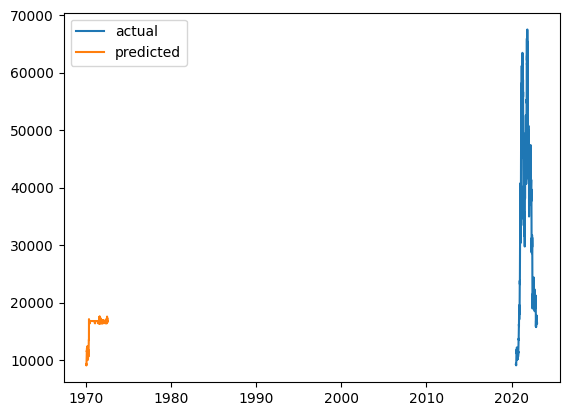

In [174]:
import lightgbm as lgb
import numpy as np

# Split the data into training and testing sets
df_train = df.iloc[:int(df.shape[0] * 0.7), :]
df_test = df.iloc[int(df.shape[0] * 0.7):, :]

# Define the features and target
features = df_train.drop(['Adj_Close'], axis=1).columns.tolist()
target = 'Adj_Close'

# Convert the data into LightGBM dataset format
d_train = lgb.Dataset(df_train[features], label=df_train[target])

# Train the model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_seed': 0,
    'verbose': -1
}
model = lgb.train(params, d_train, num_boost_round=1000)

# Make predictions on the test data
predictions = model.predict(df_test[features])

# Plot the actual and predicted values
plt.plot(df_test['Adj_Close'], label='actual')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()


In [178]:
df = df.reset_index()

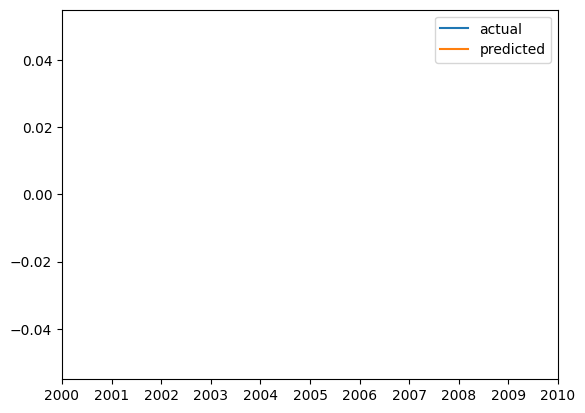

In [179]:
df_test['Date'] = df['Date'].iloc[int(df.shape[0] * 0.7):]





df_test = df_test.set_index("Date")
plt.plot(df_test.index, df_test['Adj_Close'], label='actual')
plt.plot(df_test.index, predictions, label='predicted')
plt.legend()
plt.show()

In [104]:
import pmdarima as pm

In [105]:
df_1 = df_day.copy()

In [106]:
# basically creating a range that includes all data
start = '2012-01-01'
end = '2023-01-01'

# find rows between start and end time 
df_1 = df_1[(df_1.index >= start) & (df_1.index <= end)]
df_1.tail()

,Open,High,Low,Close,Volume,Adj_Close
Date,,,,,,
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,1.574858e+10,16717.173828
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,1.700571e+10,16552.572266
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,16642.341797
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,1.592916e+10,16602.585938
2022-12-31,16603.673828,16628.986328,16517.519531,16547.496094,1.123919e+10,16547.496094


In [107]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3028 entries, 2014-09-17 to 2022-12-31
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3028 non-null   float64
 1   High       3028 non-null   float64
 2   Low        3028 non-null   float64
 3   Close      3028 non-null   float64
 4   Volume     3028 non-null   float64
 5   Adj_Close  3028 non-null   float64
dtypes: float64(6)
memory usage: 165.6 KB


In [108]:
exogenous_features = ['Open','High','Low','Close','Volume']

In [109]:
model = pm.auto_arima(data_train.Adj_Close, exogenous=data_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(data_train.Adj_Close, exogenous=data_train[exogenous_features])

forecast = model.predict(n_periods=len(data_test), exogenous=data_test[exogenous_features])
data_test["ARIMAX_Pred"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=32779.846, Time=1.65 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=34285.880, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=33673.661, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=32775.028, Time=0.49 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=32776.138, Time=1.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=32776.118, Time=0.73 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=32776.149, Time=1.71 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 6.595 seconds


In [110]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2299
Model:               SARIMAX(0, 2, 1)   Log Likelihood              -16385.514
Date:                Fri, 10 Feb 2023   AIC                          32775.028
Time:                        22:11:50   BIC                          32786.507
Sample:                    09-17-2014   HQIC                         32779.214
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9859      0.002   -560.079      0.000      -0.989      -0.982
sigma2      9.182e+04    780.754    117.605      0.000    9.03e+04    9.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):             52425.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):             834.84   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
mixed_data3 = pd.concat([data_test, data_train], sort=False)
mixed_data3.head()

,Open,High,Low,Close,Volume,Adj_Close,M_LSTM_Pred,Uni_LSTM_Pred,ARIMAX_Pred
Date,,,,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,6.786542e+10,32127.267578,31895.817795,32196.068317,29558.895796
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,7.866524e+10,32782.023438,33526.953897,32836.730641,29743.639248
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,8.116348e+10,31971.914062,32334.558347,32043.782737,29928.382700
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,6.754732e+10,33992.429688,33459.232394,34015.971307,30113.126152
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,7.528943e+10,36824.363281,35920.930452,36746.668114,30297.869605


<AxesSubplot:title={'center':'Actual Weighted Price vs ARIMAX Price Prediction'}, xlabel='Date'>

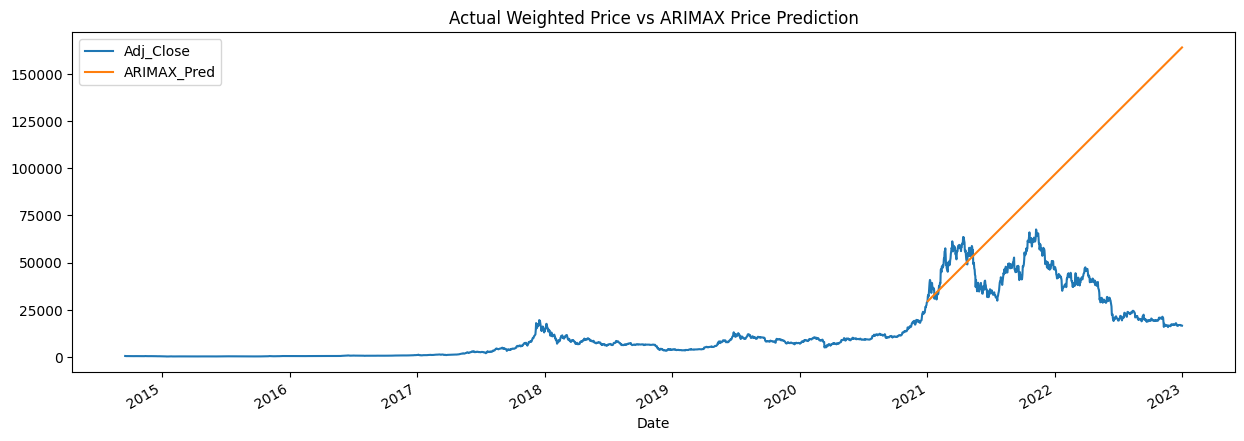

In [112]:
mixed_data3[['Adj_Close','ARIMAX_Pred']].plot(figsize=(15, 5),title=('Actual Weighted Price vs ARIMAX Price Prediction'))

Text(0.5, 1.0, 'Weighted Price vs Arimax Prediction')

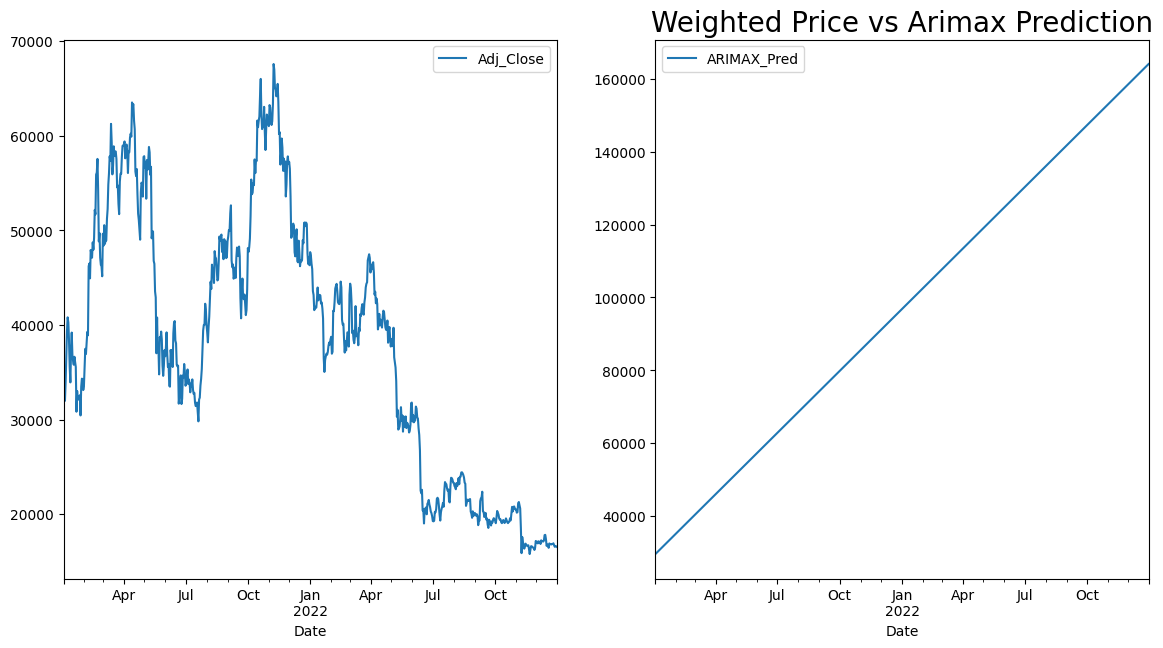

In [113]:
# For Monthly Frequency ACF and PACF

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

data_test[["Adj_Close"]].plot(figsize=(14, 7), ax=ax1)

data_test[["ARIMAX_Pred"]].plot(figsize=(14, 7), ax=ax2)
plt.title("Weighted Price vs Arimax Prediction", size=20)


In [114]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Adj_Close'],
                   y_pred=data_test['ARIMAX_Pred']))
print('RMSE:',rmse)

RMSE: 77179.94792612857


In [115]:

mean_absolute_error(y_true=data_test['Adj_Close'],
                   y_pred=data_test['ARIMAX_Pred'])

61770.54560255318

In [116]:
r2_score(data_test['Adj_Close'], data_test['ARIMAX_Pred'])

-29.971907423560367

# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------

## <font color= blue >8. Results comparison </font> <a class="anchor" id="fifth-bullet"></a>

In [ ]:
mixed_data3['Prophet_Pred'] = data_compare['prophet']
final_comp = mixed_data3.copy()
display(final_comp.head())

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Weighted_Price, name='Weighted_Price',
                         line=dict(color='chartreuse', width=4)))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.M_LSTM_Pred, name = 'M_LSTM_Pred',
                         line=dict(color='coral', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Uni_LSTM_Pred, name='Uni_LSTM_Pred',
                         line=dict(color='crimson', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.ARIMAX_Pred, name='ARIMAX_Pred',
                         line = dict(color='cyan', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Prophet_Pred, name='Prophet_Pred',
                         line=dict(color='darkblue', width=4, dash='dot')))
fig.update_layout(title='Models Comparison',
                   xaxis_title='Years',
                   yaxis_title='USD (thousands)')
fig.show()

In [ ]:
# split data into train and test sets
splitter= '2019-01-01'
df_results = final_comp[['Weighted_Price','M_LSTM_Pred','Uni_LSTM_Pred','ARIMAX_Pred','Prophet_Pred']]
df_results = df_results.loc[df_results.index > splitter]

display(df_results.head())


# Plot 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Weighted_Price, name='Weighted_Price',
                         line=dict(color='chartreuse', width=4)))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.M_LSTM_Pred, name = 'M_LSTM_Pred',
                         line=dict(color='coral', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Uni_LSTM_Pred, name='Uni_LSTM_Pred',
                         line=dict(color='crimson', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.ARIMAX_Pred, name='ARIMAX_Pred',
                         line = dict(color='yellow', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Prophet_Pred, name='Prophet_Pred',
                         line=dict(color='darkblue', width=4, dash='dot')))
fig.update_layout(title='Models Comparison',
                   xaxis_title='Years',
                   yaxis_title='USD (thousands)')
fig.show()

In [ ]:
# PLOTS
fig = plt.figure(figsize=[35, 15])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_results.Weighted_Price, '-', label='Real')
plt.legend()
plt.subplot(221)
plt.plot(df_results.M_LSTM_Pred, '-', label='M_LSTM_Pred')
plt.legend()
plt.subplot(221)
plt.plot(df_results.Uni_LSTM_Pred, '-', label='UNI_LSTM')
plt.legend()
plt.subplot(221)
plt.plot(df_results.ARIMAX_Pred, '-', label='Arimax')
plt.legend()
plt.subplot(221)
plt.plot(df_results.Prophet_Pred, '-', label='Prophet')
plt.legend()
plt.show()

In [ ]:
df_results

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['M_LSTM_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['M_LSTM_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['M_LSTM_Pred']))

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Uni_LSTM_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Uni_LSTM_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['Uni_LSTM_Pred']))

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['ARIMAX_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['ARIMAX_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['ARIMAX_Pred']))

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Prophet_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Prophet_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['Prophet_Pred']))